# 作业5：RNN 生成模型

## Instructions

以 `data/names.txt` 中的英文名作为训练集，利用 RNN 或 LSTM 等方法对字母序列数据进行建模，然后使用拟合的模型随机生成20个名字。本次作业为开放式，不指定各类超参数（如网络结构、学习率、迭代次数等），但需提供必要的输出和诊断结果支持你的选择（如模型是否收敛、效果评价等）。

提示：可以参照 `lec12-rnn-generation.zip` 中的代码，但注意英文名不需要像中文那样构建字典，因为可以直接使用26个字母作为字典。

## 1. 处理数据

In [2]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import itertools
import collections
import matplotlib.pyplot as plt

In [3]:
# load txt file

def read_txt_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read().split()
        return content

dat = read_txt_file('data/names.txt')
print(dat[:5])

['abbas', 'abbey', 'abbott', 'abdi', 'abel']


In [4]:
# construct dictionary
charset_size = 27 # 26 letters  + 1 <EOS>
dictionary = list('abcdefghijklmnopqrstuvwxyz') + ['<EOS>'] 
print(dictionary)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '<EOS>']


In [78]:
# names to tensor


def char2tensor(char):
    """将单个字符转换为 one-hot 编码的张量"""
    tensor = torch.zeros(1, charset_size) # 相当于一个列向量，长度为charset_size，相当于是对于每个字符对应的one-hot编码向量
    tensor[0, char2index(char)] = 1 # 初始化全员为0，在index位置为1
    return tensor

def name2tensor(name):
    """将名字转换为 one-hot 编码的张量"""
    tensor = torch.zeros(len(name), 1, charset_size) #一个tensor（其实是2d矩阵的感觉），第一个维度是名字的长度（名字中的各个字符），第二个维度是1，第三个维度是每个字符的onehot
    for i, char in enumerate(name): #enmuerate
        tensor[i, 0, char2index(char)] = 1
    return tensor

def char2index(char):
    """Transform a character to its index in the dictionary
    Args:
        char (str): a character
        
    Returns:
       int: the index of the character in the dictionary
        
    """
    return dictionary.index(char.lower()) 

def names2tensor(NameList):
    """Transform a list of names to one-hot tensor
    Args:
        NameList (array): a list of names
        
    Returns:
        tensor: a tensor of shape (LongestNameLength, NumberOfNames, charset_size=27), storing the one-hot representation of names
        array: a numpy array of shape (NumberOfNames), storing each name's length
        target: a tensor of shape (LongestNameLength, NumberOfNames), storing the index of the next letter
        
    """
    names_num = len(NameList) # number of names
    names_lens = [len(name) for name in NameList] # a list storing each name's length
    max_name_len = max(names_lens) # the longest name's length
    
    tensor = torch.zeros(max_name_len, names_num, charset_size) # (each char in a name, each name, one-hot vector)
    target = torch.zeros(max_name_len, names_num, dtype=int) + charset_size - 1 # initialize with <EOS>
    
    for name_i in range(names_num): # for each name(idx) in data set
        name = NameList[name_i] # get the name
        for char_i in range(names_lens[name_i]): # for each char(idx) in the name
            # set tensor
            tensor[char_i, name_i, char2index(name[char_i])] = 1 # set the corresponding one-hot vector
            # set target
            if char_i < names_lens[name_i] - 1: # if not the last char (here note that python index starts from 0)
                target[char_i, name_i] = char2index(name[char_i + 1]) # target for name_i, char_i is char_i+1
                
    return tensor, np.array(names_lens), target

# test names2tensor
names2tensor(["leon","rachel"])

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,

## 2. 构建LSTM模型类

![](https://michael-1313341240.cos.ap-shanghai.myqcloud.com/202312042025464.png)

Parameters Definition:

- Suppose there are $h$ hidden units, batch size is $n$, number of inputs is $d$. Thus, $X_t \in \mathbb{R}^{n\times h}, H_t = \mathbb{R}^{n\times h}.$
- Define Gates (at time $t$):
    - Input gate ($I_t \in \mathbb{R}^{n\times h}$) : $I_t = \text{sigmoid}(X_t W_{xi} + H_{t-1} W_{hi} + b_i)$
    - Forget gate ($F_t \in \mathbb{R}^{n\times h}$) : $F_t = \text{sigmoid}({X_t W_{xf} + H_{t-1} W_{hf} + b_f)}$
    - Output gate ($O_t \in  \mathbb{R}^{n\times h}$) : $O_t = \text{sigmoid}{X_t W_{xo} + H_{t-1} W_{ho} + b_o)}$
  
  where $W_{x,\cdot} \in \mathbb{R}^{d\times h}$, $W_{h,\cdot} \in \mathbb{R}^{h\times h}$, $b_{\cdot} \in \mathbb{R}^{1\times h}$.

- Define Candidate Memory Cell $\tilde C$:

$$
  \tilde C_t = \text{tanh}(X_t W_{xc} + H_{t-1} W_{hc} + b_c)
$$

> *Reference*
>
> *1. Dive Into Deep Learning (https://zh.d2l.ai/chapter_recurrent-modern/lstm.html)*
>

In [54]:
# Build LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM,self).__init__()
        
        self.hidden_size = hidden_size #?
        
        self.X2F = nn.Linear(in_features = input_size + hidden_size,
                            out_features = hidden_size )
        self.X2I = nn.Linear(in_features = input_size + hidden_size,
                            out_features = hidden_size )
        self.X2O = nn.Linear(in_features = input_size + hidden_size,
                            out_features = hidden_size )
        
        self.X2Ct = nn.Linear(in_features = input_size + hidden_size,
                            out_features = hidden_size )
        
        self.O2O = nn.Linear(in_features = hidden_size,
                            out_features = hidden_size)
        
        self.dropout = nn.Dropout(0.1)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden, MemCell):
        
        input_combined = torch.cat((input,hidden),1)     #? how
        
        ForgetGate = torch.sigmoid(self.X2F(input_combined))   
        InputGate = torch.sigmoid(self.X2I(input_combined))
        OutputGate = torch.sigmoid(self.X2O(input_combined))
        
        CandidateMemCell = torch.tanh(self.X2Ct(input_combined))
        
        MemCell = ForgetGate * MemCell + InputGate * CandidateMemCell
        
        hidden = OutputGate * torch.tanh(MemCell)
        # print(f"hidden:{hidden.shape}")
        
        output = self.O2O(hidden)
        output = self.dropout(output)
        output = self.logsoftmax(output)
        
        return output, hidden, MemCell
    
    def init_hidden(self, batch_size, device):
        return torch.zeros((batch_size, self.hidden_size), device = device)

    def init_MemCell(self, batch_size, device):
        return torch.zeros((batch_size, self.hidden_size), device = device)


*Test Demo*

In [7]:
n_hidden = 64
lstm = LSTM(charset_size, n_hidden)


input = name2tensor("leon")
#print(input)
hidden = lstm.init_hidden(batch_size=1, device='cpu')
MemCell = lstm.init_MemCell(batch_size=1, device='cpu')

print(input[0])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [8]:
output, next_hidden, next_MemCell  = lstm(input[0], hidden, MemCell)
print(output)

hidden:torch.Size([1, 64])
tensor([[-4.2916, -4.3366, -4.0525, -4.1805, -4.2337, -4.2706, -4.0466, -4.1242,
         -4.2224, -4.2804, -4.1828, -4.1893, -4.0679, -4.0881, -4.1348, -4.1828,
         -4.0557, -4.1326, -4.2659, -4.1828, -4.0906, -4.1754, -4.1828, -4.0477,
         -4.1245, -4.1765, -4.1828, -4.1402, -4.1005, -4.1389, -4.1056, -4.0383,
         -4.0433, -4.1828, -4.2336, -4.2517, -4.2207, -4.2642, -4.2757, -4.1096,
         -4.1315, -4.0161, -4.2992, -4.1532, -4.2450, -4.1176, -4.2392, -4.1018,
         -4.0551, -4.0704, -4.1273, -4.0466, -4.1828, -4.1392, -4.1422, -4.2710,
         -4.2520, -4.2208, -4.2135, -4.1009, -4.1939, -4.0509, -4.1422, -4.2458]],
       grad_fn=<LogSoftmaxBackward0>)


***Train LSTM***

In [66]:
# set random seed 
np.random.seed(123)
torch.random.manual_seed(123)

# set device
device = torch.device("cuda") 

# set hyper-params
train = dat
train_size = len(train)
n_hidden = 256
n_epoch = 100
batch_size = 256
learning_rate = 0.001

# create LSTM

## Initialization
lstm = LSTM(input_size = charset_size, hidden_size = n_hidden) # create lstm
lstm = lstm.to(device=device) # set gpu/cpu

## Optimization
opt = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

## Loss Function
lossfn = nn.NLLLoss(reduction='none') # ? reduction='none'
losses = []

## Training Structure

train_ind = np.arange(train_size) # train_ind for mini-batch shuffle

epoch0/100,loss = 4.990899562835693
epoch1/100,loss = 3.7747414112091064
epoch2/100,loss = 3.6550323963165283
epoch3/100,loss = 3.4169921875
epoch4/100,loss = 3.375164031982422
epoch5/100,loss = 3.3369686603546143
epoch6/100,loss = 3.2019920349121094
epoch7/100,loss = 3.2043941020965576
epoch8/100,loss = 3.1698474884033203
epoch9/100,loss = 3.1644561290740967
epoch10/100,loss = 3.0841116905212402
epoch11/100,loss = 2.98093318939209
epoch12/100,loss = 3.0438320636749268
epoch13/100,loss = 2.9033026695251465
epoch14/100,loss = 2.887643814086914
epoch15/100,loss = 2.9243290424346924
epoch16/100,loss = 2.744793653488159
epoch17/100,loss = 2.649574041366577
epoch18/100,loss = 2.7562148571014404
epoch19/100,loss = 2.709465503692627
epoch20/100,loss = 2.6703109741210938
epoch21/100,loss = 2.6483817100524902
epoch22/100,loss = 2.573634147644043
epoch23/100,loss = 2.657068967819214
epoch24/100,loss = 2.551311731338501
epoch25/100,loss = 2.549558162689209
epoch26/100,loss = 2.5637245178222656
ep

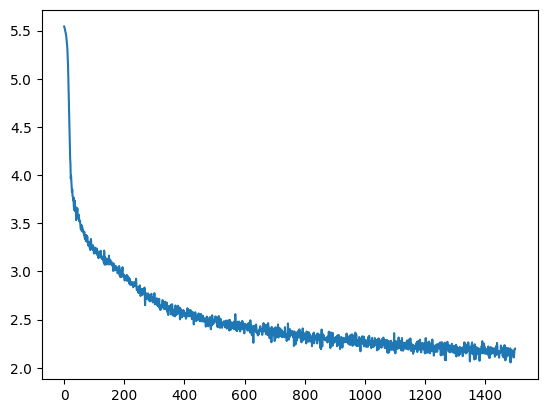

In [67]:

t1 = time.time() # timing 

for epoch in range(n_epoch): # start training
    np.random.shuffle(train_ind) # shuffle
    
    for batch_i in range(0, train_size, batch_size): # batch_i: i'th batch start index
        
        # create minibatch_i
        index_list = train_ind[batch_i:(batch_i+batch_size)] # get i'th batch's index list
        minibatch = [train[id]  for id in index_list ] # from index get i'th minibatch list
        minibatch_size = len(minibatch) # get i'th minibatch size
        
        # transform input name: char -> tensor
        input, actual_len, target = names2tensor(minibatch) # input: each name's one-hot tensor, actual_len: actual lenth of each name
        input = input.to(device=device) # transfer input to device
        target = target.to(device=device) # transfer input to device
        max_name_len = input.shape[0] # by definition of names2tensor
        
        # initialization 
        hidden = lstm.init_hidden(minibatch_size,device=device) # initialize hidden layer
        MemCell = lstm.init_MemCell(minibatch_size,device=device) # initialize MemCell
        
        # compute loss function
        loss = 0.0 # initialize loss function
        
        for name_i in range(max_name_len): # put data into LSTM char by char
            output, hidden, MemCell = lstm(input[name_i], hidden, MemCell) #input[char_i]
            loss_i = lossfn(output,target[name_i])
            valid = torch.tensor( (name_i < actual_len).astype(int)).to(device=device)
            loss += loss_i * valid
        
        loss = torch.mean(loss / torch.tensor(actual_len).to(device=device))    
        
        # opt the loss fn
        opt.zero_grad() # initialize optimizer
        loss.backward() # backward for gradient
        opt.step() # update params
        
        losses.append(loss.item()) # ?
     
    print(f"epoch{epoch}/{n_epoch},loss = {loss.item()}")
            
t2 = time.time()

print(f"Total time: {t2-t1}")

plt.plot(losses)
        
        
        

***TEST OUTPUT***

In [69]:
# test output ???

torch.save(lstm.state_dict(), "name.pt")
lstm.load_state_dict(torch.load("name.pt", map_location=device))
lstm.eval()

LSTM(
  (X2F): Linear(in_features=283, out_features=256, bias=True)
  (X2I): Linear(in_features=283, out_features=256, bias=True)
  (X2O): Linear(in_features=283, out_features=256, bias=True)
  (X2Ct): Linear(in_features=283, out_features=256, bias=True)
  (O2O): Linear(in_features=256, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (logsoftmax): LogSoftmax(dim=1)
)

In [75]:
first_char = list('abcdefghijklmnoprstuvwxyz')

def gen_FirstChar():
    """generate first character from a~z"""
    return np.random.choice(first_char,1)[0]

def gen_Names(max_lenth = 4):
    lstm.eval() # eval mode (because of dropout)
    
    first_char = gen_FirstChar() # randomly generate form 'a~z'
    input = char2tensor(first_char).to(device=device) # get input into tensor
    char_ind = [torch.argmax(input).item()] # the index of this character (in alphabet), we need this for char recovery
    
    hidden = lstm.init_hidden(batch_size=1,device=device)
    MemCell = lstm.init_MemCell(batch_size=1,device=device)
    
    for chr in range(max_lenth - 1):
        output, hidden = lstm


'm'

---

In [11]:
n_hidden = 64
lstm = LSTM(charset_size, n_hidden)
def name2tensor(name):
    """将名字转换为 one-hot 编码的张量"""
    tensor = torch.zeros(len(name), 1, charset_size) #一个tensor（其实是2d矩阵的感觉），第一个维度是名字的长度（名字中的各个字符），第二个维度是1，第三个维度是每个字符的onehot
    for i, char in enumerate(name): #enmuerate
        tensor[i, 0, char2index(char)] = 1
    return tensor

input = name2tensor("leon")
#print(input)
hidden = lstm.init_hidden(batch_size=1, device='cpu')
MemCell = lstm.init_MemCell(batch_size=1, device='cpu')

print(input[0])
#output, next_hidden, next_MemCell  = lstm(input[0], hidden, MemCell)
#print(output)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])
